### Introduction

This time the goal is to go through some basic Machine Learning practices. We will use data we have been working on so far.

### Goal

The goal for this exercise is to create a Machine Learning model that will predict total number of bike rentals on a given day.

Even though, there may be more interesting things to look for in the data we have, this will be good opportunity to go through the process and then everyone should be able to work on other predictions.

This doesn't really take into consideration which stations were the bikes rented from or returned to. It doesn't matter what the routes were, etc. We only care for the total number of rentals for a given day.

### Requirements

We need to enrich the data and then prepare it for ML training. When this is done, we can eventually execute the models and evaluate them.

In [1]:
# Let's start with initial imports we definitelly need across the whole notebook
import pandas as pd
import numpy as np

In [2]:
# Next, we load the data and have a glance at it
wyp = pd.read_csv('../../data/wyp_2018_prepared.csv')

In [3]:
wyp.sample(5)

,bike_num,start_time,end_time,departure,return,duration_sec,start_day,start_month,start_hour,start_minute,...,is_free,shop,route,dep_id,dep_lat,dep_lon,ret_id,ret_lat,ret_lon,distance
23951,58466,2018-04-30 14:19:45,2018-04-30 14:26:09,Katowice Rynek,Plac Sejmu Śląskiego,384,30,4,14,19,...,0,2,Katowice Rynek - Plac Sejmu Śląskiego,5867,50.258697,19.021618,5876,50.253840,19.023791,0.561986
139005,58504,2018-09-07 18:44:33,2018-09-07 18:48:57,Szopienice - Plac Powstańców Śląskich,Szopienice - Plac Powstańców Śląskich,264,7,9,18,44,...,0,2,Szopienice - Plac Powstańców Śląskich - Szopie...,5862,50.262446,19.095088,5862,50.262446,19.095088,0.000000
140175,58863,2018-09-09 15:28:02,2018-09-09 16:27:14,Galeria 3 Stawy,Galeria 3 Stawy,3552,9,9,15,28,...,0,0,Galeria 3 Stawy - Galeria 3 Stawy,5897,50.243553,19.036291,5897,50.243553,19.036291,0.000000
86509,58412,2018-07-08 18:07:32,2018-07-08 18:32:20,Dolina 3-ch Stawów,Nikiszowiec Lodowisko Jantor,1488,8,7,18,7,...,0,0,Dolina 3-ch Stawów - Nikiszowiec Lodowisko Jantor,5869,50.233217,19.027812,5863,50.244896,19.082225,4.093414
151808,58707,2018-09-30 17:00:55,2018-09-30 17:20:22,Dolina 3-ch Stawów,Galeria 3 Stawy,1167,30,9,17,0,...,0,1,Dolina 3-ch Stawów - Galeria 3 Stawy,5869,50.233217,19.027812,5897,50.243553,19.036291,1.299089


Our goal here is to predict the total (from all stations) number of renatals for a given day. You should think which columns are helpful for that, and which are not. We need to get rid of those that do not add any useful information for this particular task. 

Let's get rid of those that are pretty obvious first.

In [4]:
wyp.columns

Index(['bike_num', 'start_time', 'end_time', 'departure', 'return',
       'duration_sec', 'start_day', 'start_month', 'start_hour',
       'start_minute', 'month_day', 'duration_min', 'duration_hour',
       'which_day', 'daynumber', 'is_weekend', 'is_free', 'shop', 'route',
       'dep_id', 'dep_lat', 'dep_lon', 'ret_id', 'ret_lat', 'ret_lon',
       'distance'],
      dtype='object')

In [5]:
wyp_ml = wyp.drop(columns = ['bike_num', 'start_time', 'end_time', 'departure', 'return',
                             'duration_sec', 'start_hour', 'start_minute', 'month_day',
                             'duration_min', 'duration_hour', 'route', 'dep_id', 'dep_lat', 'dep_lon',
                             'ret_id', 'ret_lat', 'ret_lon', 'distance'])

In [6]:
wyp_ml.sample(5)

,start_day,start_month,which_day,daynumber,is_weekend,is_free,shop
85059,7,7,5,188,1,0,2
14564,19,4,3,109,0,0,2
59833,10,6,6,161,1,0,0
14939,20,4,4,110,0,0,2
125271,21,8,1,233,0,0,2


As you can see, we dropped quite a few columns. But this will be very simple use case for which the information in them is not relevant for us. You may want to double check on that though, we will see how further in the notebook.

The prediction should tell us how many rentals will be there for a given day, so to train a model, we need to feed it with that information from the past. In its current form, the dataframe doesn't really show it, we need to count the rentals and add it to our set.

In [7]:
sums = wyp_ml.groupby(['start_day', 'start_month'])['which_day'].count()
sums = sums.to_frame()
sums = pd.DataFrame(sums.to_records())
sums = sums.rename({'which_day': 'count'}, axis=1)
sums.sample(5)

,start_day,start_month,count
128,15,6,1054
35,4,12,95
137,16,6,1232
176,21,4,1139
62,7,12,128


Since we have saved now count of rentals per day, we can transform our DF so that it has a single row per day with the rentals number included.

In [8]:
print(len(wyp_ml))
wyp_ml_drooped = wyp_ml.drop_duplicates()
print(len(wyp_ml_drooped))

171400
260


In [9]:
wyp_ml_2 = wyp_ml_drooped.merge(sums, left_on=['start_day', 'start_month'], right_on=['start_day', 'start_month'], how='left')
wyp_ml_2.reset_index(drop=True, inplace=True)
wyp_ml_2.head(5)

,start_day,start_month,which_day,daynumber,is_weekend,is_free,shop,count
0,1,4,6,91,1,1,0,44
1,2,4,0,92,0,1,2,249
2,3,4,1,93,0,0,2,476
3,4,4,2,94,0,0,2,510
4,5,4,3,95,0,0,2,629


One last thing that seems to might have significant impact on the rentals number is weather. There are many ways to get weather information and add it to our data frame. We're not going into any details at this point however, simply load the data provided in a file.

In [10]:
weather = pd.read_csv('../../data/weather.csv', index_col = 0)

In [11]:
weather.head(10)

,daynumber,dayofweek,mintemp,maxtemp,rain,meantemp,dewp,visib,mxpsd,sndp,fog
0,365,2,32.0,37.6,0.38,33.9,31.7,5.9,12.0,0.0,0
1,364,1,34.3,39.0,0.07,36.6,34.6,4.0,13.0,0.0,0
2,363,7,35.6,40.3,0.05,37.7,36.4,4.0,11.1,0.0,0
3,362,6,37.4,41.4,0.08,38.3,37.0,5.4,12.0,0.0,0
4,361,5,36.7,42.8,0.06,39.1,37.9,4.5,14.0,0.0,1
5,360,4,35.1,38.1,0.14,36.3,34.3,5.5,15.0,0.0,0
6,359,3,28.4,36.3,0.02,32.0,29.8,5.0,12.0,0.4,0
7,358,2,28.4,40.5,0.27,32.7,29.5,5.2,15.9,0.0,0
8,357,1,33.8,40.8,0.35,37.5,35.4,5.2,12.0,0.0,0
9,356,7,35.6,47.1,0.08,41.5,37.3,6.1,19.0,0.0,0


In [12]:
# Let's add it to our main dataframe

wyp_ml_3 = pd.merge(weather, wyp_ml_2, on='daynumber')
wyp_ml_3.reset_index(drop=True, inplace=True)
wyp_ml_3.sample(10)

,daynumber,dayofweek,mintemp,maxtemp,rain,meantemp,dewp,visib,mxpsd,sndp,fog,start_day,start_month,which_day,is_weekend,is_free,shop,count
231,113,2,35.6,75.2,0.35,57.8,43.8,6.800000,15.0,0.0,0,23,4,0,0,0,2,641
52,292,6,42.8,54.5,0.00,47.7,46.5,1.100000,7.0,0.0,1,19,10,4,0,0,2,376
252,92,2,28.4,51.1,0.02,38.0,26.4,6.500000,21.0,0.0,0,2,4,0,0,1,2,249
211,133,1,42.8,74.1,0.00,62.9,41.3,5.147649,18.1,0.0,0,13,5,6,1,0,0,1113
109,235,5,59.0,90.0,0.00,75.2,55.1,9.300000,11.1,0.0,0,23,8,3,0,0,2,1089
2,348,6,28.4,31.8,0.00,28.9,26.3,4.800000,8.9,1.6,0,14,12,4,0,0,2,65
193,151,5,53.6,84.6,0.00,68.2,55.4,4.400000,18.1,0.0,0,31,5,3,0,1,2,1246
130,214,5,62.6,87.1,0.00,74.9,63.2,5.100000,9.7,0.0,0,2,8,3,0,0,2,950
253,91,1,33.8,54.0,0.08,37.5,33.4,4.900000,22.0,0.0,0,1,4,6,1,1,0,44
116,228,5,53.6,78.8,0.00,66.2,54.6,6.500000,8.0,0.0,0,16,8,3,0,0,2,974


In [13]:
# At this moment we should drop columns with duplicated data

wyp_ml_4 = wyp_ml_3.drop(columns = ['daynumber', 'which_day'])

Before running ML algorithms it is good idea to have some sort of a benchmark. We will use mean number of rentals.

We also need to select a performance measure.

A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

There may be other better measures, but for our case the RMSE is good enough.

In [14]:
avg = np.mean(wyp_ml_4['count'])
print('Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((wyp_ml_4['count'] - avg)**2))))

Just using average=672.1102362204724 has RMSE of 349.87130881206235


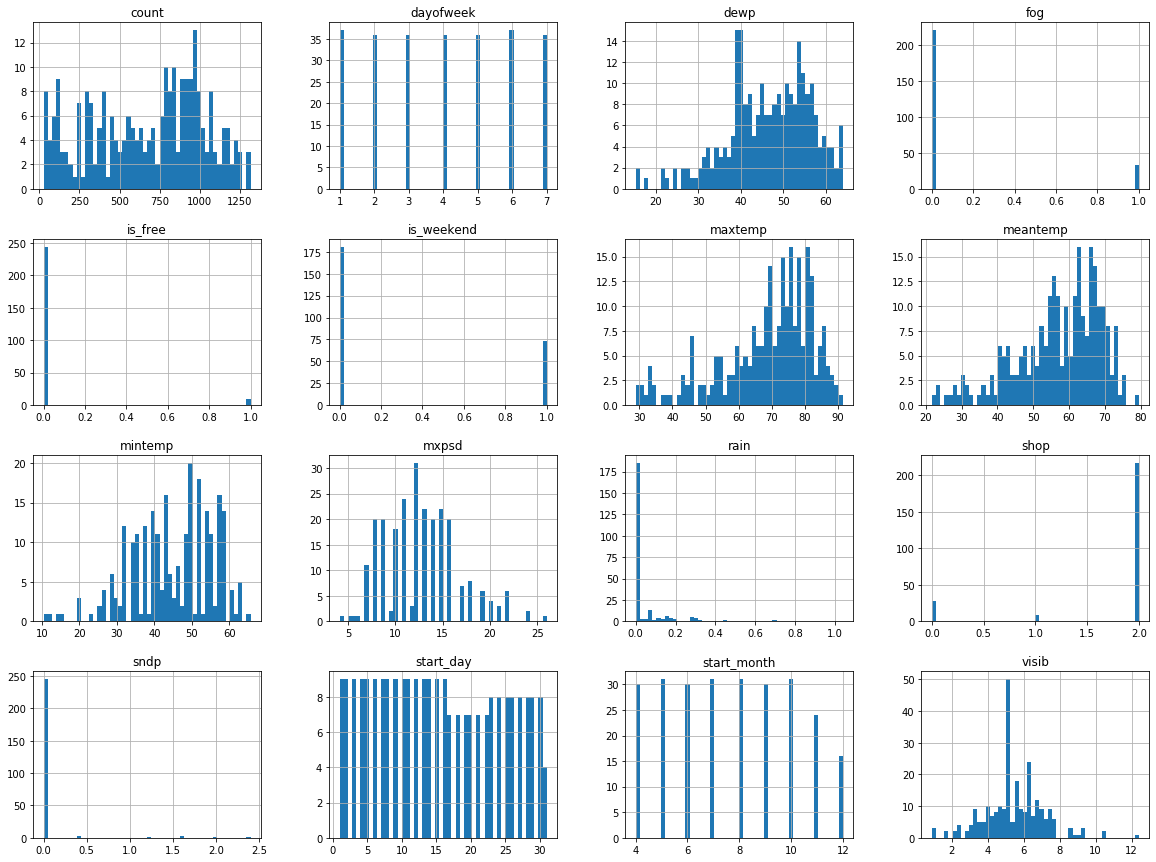

In [15]:
# To get a feel of your data, you can plot a histogram for each numerical value.
# You can see there some of the values are continuous and others seem to be categorical which we will
# further analyze in next steps.

%matplotlib inline
import matplotlib.pyplot as plt
wyp_ml_4.hist(bins=50, figsize=(20,15))
plt.show()

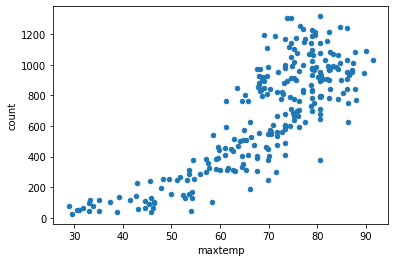

In [16]:
# Using simple scatter you can analyze dependency between features and labels

wyp_ml_4.plot(kind='scatter', x='maxtemp', y='count')

### Creating a Test Set

Let's get 20% of our dataset and save it as a test set to validate the model against when it's ready.

We could simply split the sets randomly, but a better idea might be to make sure we have good representation of data in our test set. Random sampling should be fine as long as the dataset is large enough, in this case the dataset is very small and thus we need to help with the split a little. This is called stratified sampling. The dataset is divided into homogeneous groups called strata, the goal is so that the right number of instances is sampled from each stratum for our test set to be good representation of the overall data. More here: https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36

Before running any ML models, we can predict that rain levels is significant factor for bike rentals numbers. This may not be the most relevant factor, but for that one, the distribution in the overall data is very skewed which means in a small dataset, its meaning might be easily lost.

The level of rain is continuous numerical attribute we need to create some categories for.

Looking at the rain histogram, we can say having 4 categories should be enough. Each category should be large enough to include good number of instances.

In [17]:
wyp_ml_4.rain.describe()

count    254.000000
mean       0.069528
std        0.160288
min        0.000000
25%        0.000000
50%        0.000000
75%        0.057500
max        1.040000
Name: rain, dtype: float64

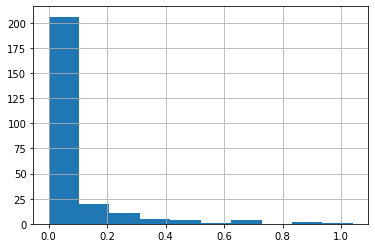

In [18]:
wyp_ml_4.rain.hist()

We will have following categories:
```
1- 0
2- 0   >= 0.3
3- 0.3 >= 0.6
4- 0.6 >=
```

In [19]:
wyp_ml_4['rain_cat'] = pd.cut(wyp_ml_4.rain, bins = [-1.0, 0.0, 0.3, 0.6, np.inf], labels = [1, 2, 3, 4])

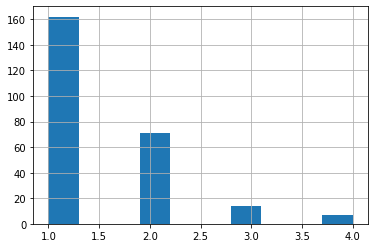

In [20]:
wyp_ml_4.rain_cat.hist()

We will use Scikit-Learn’s StratifiedShuffleSplit class to do stratified sampling based on the rain levels category:

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(wyp_ml_4, wyp_ml_4.rain_cat):
    strat_train_set = wyp_ml_4.loc[train_index]
    strat_test_set = wyp_ml_4.loc[test_index]

Let's see how many observations are there per rain levels category:

In [22]:
strat_test_set["rain_cat"].value_counts() / len(strat_test_set)

1    0.647059
2    0.274510
3    0.058824
4    0.019608
Name: rain_cat, dtype: float64

Now, this doesn't look too good, we have underrepresentation of two last categories. This is due to the fact, there is simply not enough data with observations that fits them. We need to change the categories:

```
1- 0
2- 0   >= 0.2
3- 0.2 >=
```

In [23]:
wyp_ml_4['rain_cat'] = pd.cut(wyp_ml_4.rain, bins = [-1.0, 0.0, 0.2, np.inf], labels = [1, 2, 3])

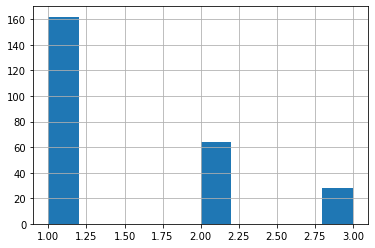

In [24]:
wyp_ml_4.rain_cat.hist()

In [25]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(wyp_ml_4, wyp_ml_4.rain_cat):
    strat_train_set = wyp_ml_4.loc[train_index]
    strat_test_set = wyp_ml_4.loc[test_index]

In [26]:
strat_test_set["rain_cat"].value_counts() / len(strat_test_set)

1    0.627451
2    0.254902
3    0.117647
Name: rain_cat, dtype: float64

It's not perfect, but quite better then it was before.

Now we can remove the rain_cat attribute to have our set in its original form

In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("rain_cat", axis=1, inplace=True)

At this point you may want to run few more visualizations on your data. Let's check how attributes correlate to each other, but first reminder of Pearson Correlation.

![Example](../../data/mlst_0214.png)

In [28]:
corr_matrix = wyp_ml_4.corr()

In [29]:
corr_matrix["meantemp"].sort_values(ascending=False)

meantemp       1.000000
maxtemp        0.964671
mintemp        0.902130
dewp           0.886608
count          0.790208
visib          0.353246
rain           0.020891
start_day      0.012111
dayofweek      0.009245
shop           0.008315
mxpsd         -0.009195
is_weekend    -0.041155
is_free       -0.043203
fog           -0.149057
sndp          -0.394396
start_month   -0.532465
Name: meantemp, dtype: float64

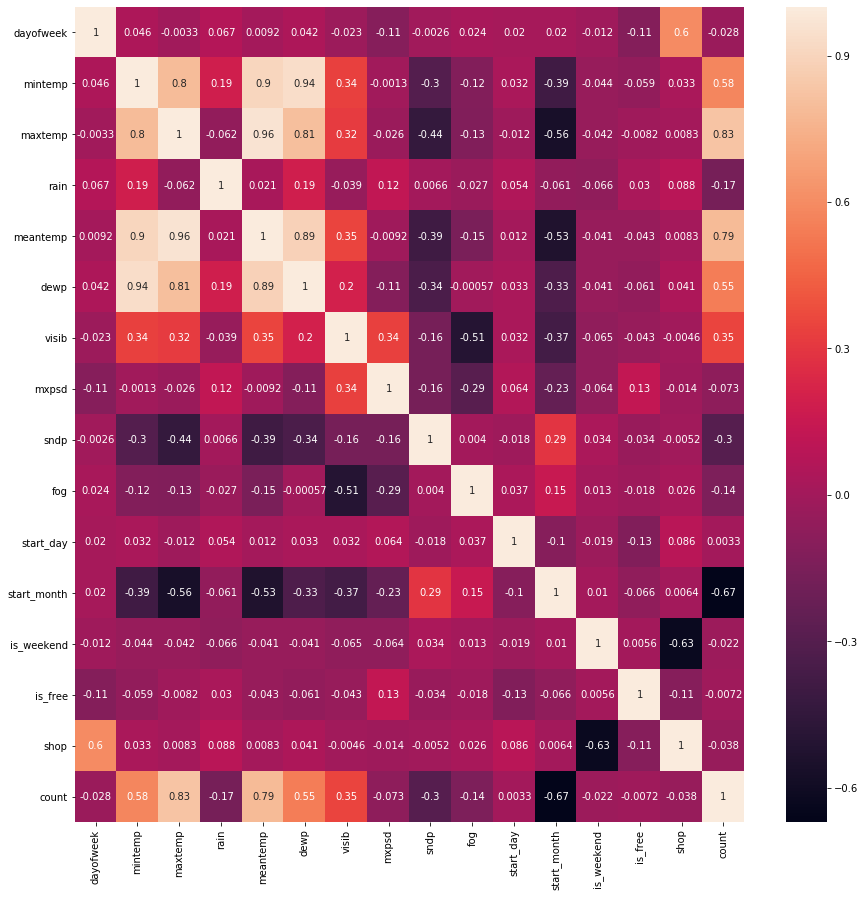

In [30]:
import seaborn as sns

plt.figure(figsize = (15, 15))
sns.heatmap(corr_matrix, annot = True)

You should further examine most promising correlations. This step, in general, is used to find out oddities in your data. Sometimes values may be capped for instance and plotting correlation scatter will reveal this. 

Other case could involve attributes with tail-heavy distribution for which you may want to transform them using their logharithm instead for instance. 

In our case let's move on. 

At some point having dedicated meeting about visualizations and quirks they can reveal could be good idea, though.

### Data Preparation for ML Algorithms

Next step is to create functions to transform the data in a way that is best suited for ML algorithms. We will start with dividing the train set to predictors and labels.

In [31]:
bikes = strat_train_set.drop("count", axis=1)
bikes_labels = strat_train_set["count"].copy()

Let's have a look at the code below and we will describe what it does once it is ran

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['dayofweek', 'fog', 'start_day', 'start_month', 'is_weekend', 'is_free', 'shop']
num_attribs = ['mintemp', 'maxtemp', 'rain', 'meantemp', 'dewp', 'visib', 'mxpsd', 'sndp']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

First of all, we need to know which attributes are numerical and which are categorical. 

Then we may want to apply transformations on each of them separately or on all attributes altogether.

In our case, num_pipeline includes transformations that will be applied on numerical attributes only. It will look for missing values and replace them with the median for the given feature. Then it will standardise all numerical attributes.

*** What do you think should be the approach here, should be standardise, normalize (min-max scaling) values or maybe a mix of both?

We have a single transformation to be applied on categorical attributes, it is one hot encoder.

In [33]:
bikes_prepared = full_pipeline.fit_transform(bikes)

*** Remember, it is important to fir scalers to the train data only, not the full dataset or the test dataset. This is especially important so that you can easily add new data for instance. 

In [34]:
pd.DataFrame(bikes_prepared.toarray())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.512797,0.091405,-0.437228,0.473900,-0.129289,-0.147510,2.373125,-0.15891,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.509560,-0.023310,-0.437228,-0.004715,-0.603366,-0.147510,0.579205,-0.15891,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.293721,0.206119,-0.437228,0.104443,0.062359,0.834263,0.579205,-0.15891,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.215667,1.331758,-0.437228,1.380751,0.869298,-0.147510,-0.189618,-0.15891,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.147670,0.528755,-0.437228,0.331155,0.576783,-0.114401,-1.778518,-0.15891,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0.476284,0.335173,-0.437228,0.389933,0.506176,0.581286,-1.214715,-0.15891,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
199,-1.166789,-1.600639,0.294791,-1.339801,-0.774841,-0.746843,0.809852,-0.15891,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
200,1.297821,0.851390,-0.437228,1.145642,0.899558,1.529950,-0.189618,-0.15891,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
201,-0.263099,0.722336,-0.437228,0.490694,-0.714320,-0.147510,1.860577,-0.15891,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


### Choosing and Training a Model!

So now it is the time for what we all waited for ... let's get on with the most interesting and spectacular part - training a Machine Learning Model!!!

We will start with Linear Regression.

In [35]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(bikes_prepared, bikes_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/LwHfaQM6AzEu44CqJO/giphy.gif">')

Well ... that wasn't spectacular at all.

But that indeed is what we need to train a model. Anyway, let's have a look at how it went.

In [37]:
from sklearn.metrics import mean_squared_error
bikes_predictions = lin_reg.predict(bikes_prepared)
lin_mse = mean_squared_error(bikes_labels, bikes_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

115.60386770995305

Not too bad - compared to our benchmark which was 340! But we can do better I'm sure. Decision Trees next

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(bikes_prepared, bikes_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [39]:
bikes_predictions = tree_reg.predict(bikes_prepared)
tree_mse = mean_squared_error(bikes_labels, bikes_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Hm ... Is this for real? No error at all? Do we have a perfect model? Well ... no. This is an example of overfitting the data, badly. How to verify this? Until you know which model to choose, you shouldn't touch the test data. Instead, you should use part of the training set for training and part for model validation.

One way to do it is by using the Scikit-Learn's cross-validation feature. It randomly splits the dataset into a number of distinct subsets called folds, then it trains and evaluates the Decision Trees model as many times as many folds there are using different fold for evaluation every time and training on the remaining 9 folds. We have an array of 10 evaluation scores as the result.

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, bikes_prepared, bikes_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [41]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [42]:
display_scores(tree_rmse_scores)

Scores: [160.01562424 171.724863   173.34716062 191.20198744 229.65441428
 250.40297522 160.58331171 159.66355251 197.46290791 254.56295881]
Mean: 194.86197557415284
Standard deviation: 35.363994994979514


Aaaand it doesn't look that good any more. In fact it seems to perform a lot worse than simple linear regression model. 

With cross-validation you also get standard deviation - a measure of how precise the estimate is. So the Decision Tree has a score of 183 +/- 37.

Let's check the score the same way for Linear Regression, though

In [43]:
lin_scores = cross_val_score(lin_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [177.41263352 213.47693386 187.97824888 210.84798686 119.16894843
 136.33754659 162.12862957 205.87500804 151.77567171 151.22675339]
Mean: 171.62283608619964
Standard deviation: 31.08234641306093


Indeed, it seems that the Decision Tree is overfitting too hard and as a result it performs worse then a Linear Regression model. 

Let's try Random Forest now.

In [44]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(bikes_prepared, bikes_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [45]:
bikes_predictions = forest_reg.predict(bikes_prepared)
forest_mse = mean_squared_error(bikes_labels, bikes_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

56.669816302886986

In [46]:
forest_scores = cross_val_score(forest_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [120.01412649 153.30820681 183.31227586 156.75600381 143.449184
 164.4550137   96.83775563 164.73653417 122.22046975 123.33998411]
Mean: 142.8429554318935
Standard deviation: 25.161328083204634


Now, this is even better. Bear in mind that the score on the training set is still significantly lower than on the validation sets. This means the model is still overfitting the training set.

### Evaluating on the Test Set

In [47]:
final_model = forest_reg

X_test = strat_test_set.drop("count", axis=1)
y_test = strat_test_set["count"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [48]:
final_rmse

156.40228638442122

### Summary

We have defined our goal, prepared the dataset with data that is significant to predict what we're looking for. Then, we have transformed the data so that it is in a form that is readable by Machine Learning algorithms. 

Eventually, we have trained a few different models and evaluated their performance.

This doesn't cover every aspect of a Machine Learning project yet, though. We haven't touched fine tuning yet for instance. We should get back to it next time.